In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
import skimage.exposure
import pandas as pd
%load_ext autoreload
%autoreload 2

In [6]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
CLEANED = os.path.join(DIR, 'preps', 'CH1', 'thumbnail_cleaned')
MASKED = os.path.join(DIR, 'preps', 'thumbnail_masked')
files = sorted(os.listdir(INPUT))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import linnorm, fix_with_fill, find_contour_count, pad_with_black, fill_spots

Connecting dklab@192.168.1.12:3306


In [4]:
bads = ['080.tif','394.tif', '401.tif']

100%|██████████| 5/5 [00:00<00:00, 45.84it/s]


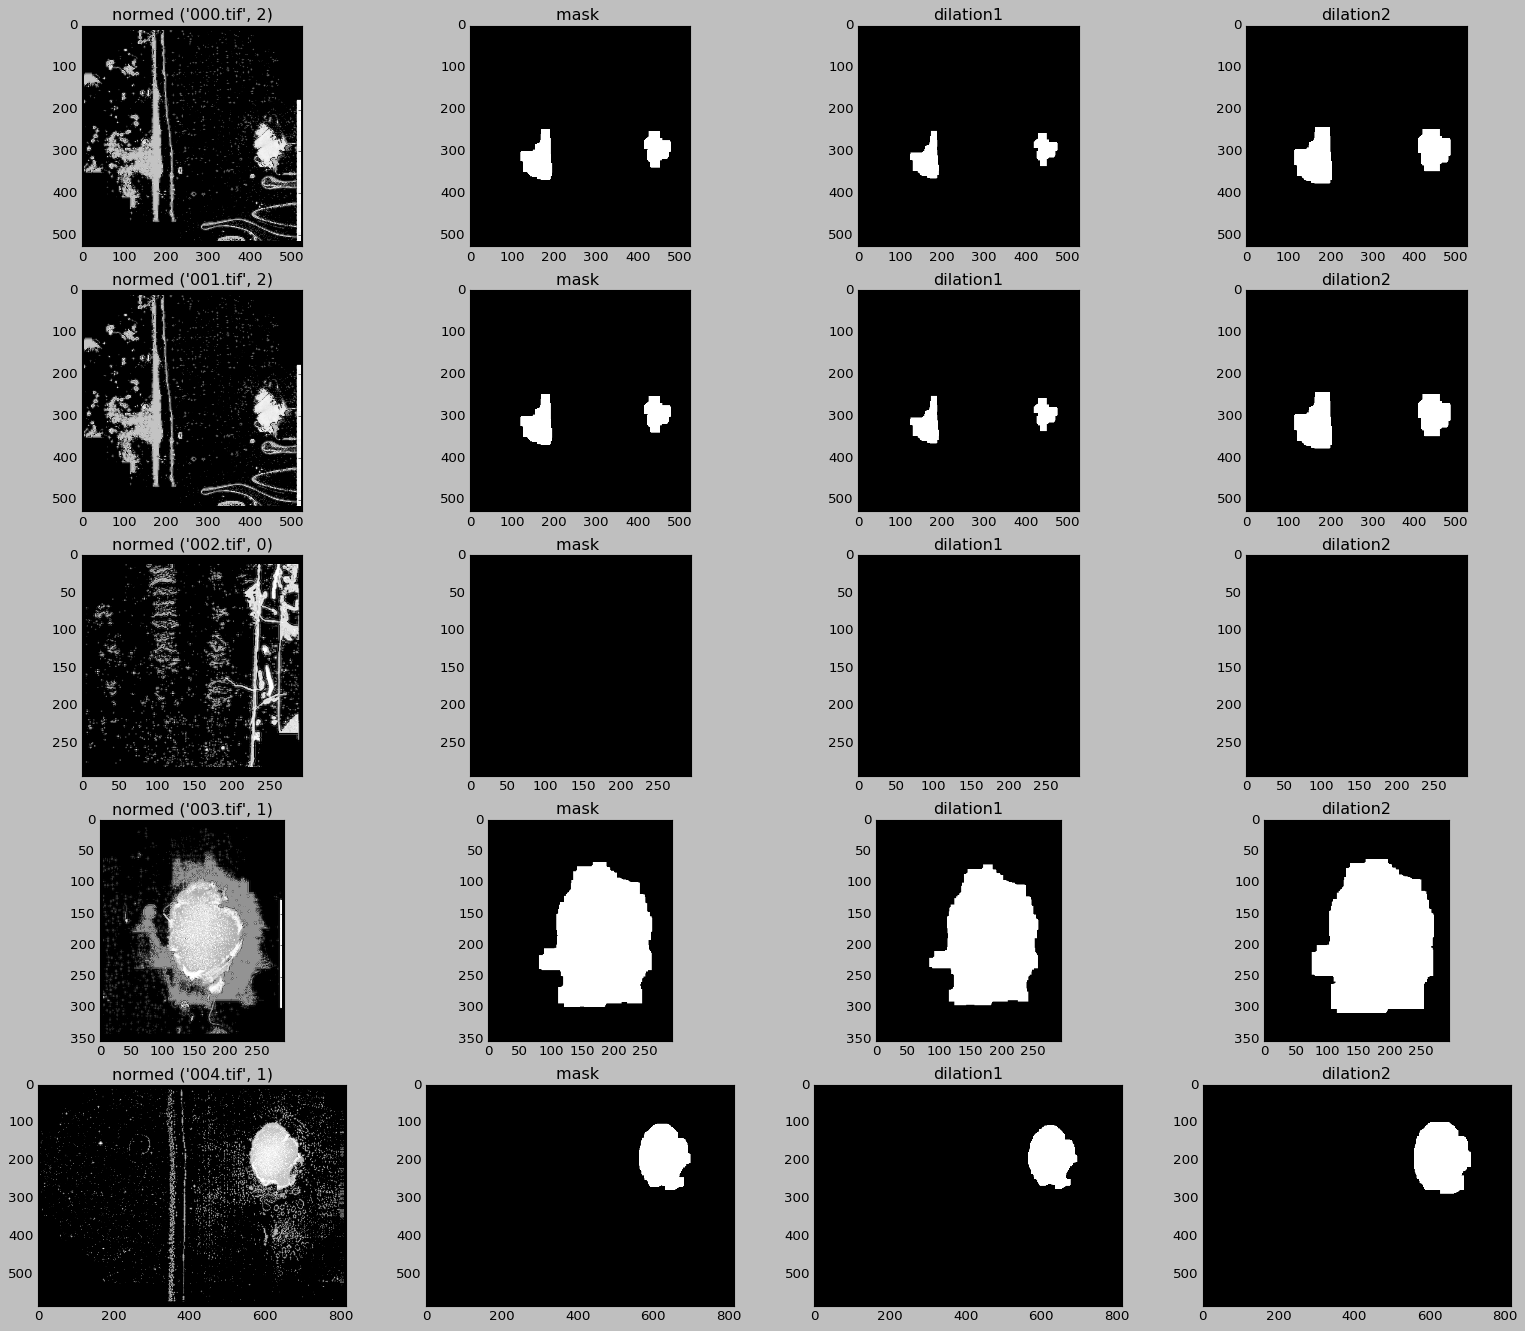

In [8]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
masks = []
limit = 250
dilations1 = []
dilations2 = []
dt = np.uint8
midpoint = len(files) // 2
small_kernel = np.ones((3, 3), np.uint8)
big_kernel = np.ones((8, 8), np.uint8)
for i, file in enumerate(tqdm(files[0:5])):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img_inputs.append(img)
    imgpad = pad_with_black(img)
    normed = linnorm(imgpad, 45000, np.uint16)
    mask = fix_with_fill(imgpad, limit, dt)
    contours = find_contour_count(mask)
    dilation1 = cv2.erode(mask,big_kernel,iterations = 1)
    dilation2 = cv2.dilate(dilation1,big_kernel,iterations = 3)
    dilation3 = fill_spots(dilation2)
    
    file_inputs.append((file,contours))
    dilations1.append(dilation1)
    dilations2.append(dilation3)
    img_outputs.append(normed)
    masks.append(mask)
    
ncols = 4
fig, ax = plt.subplots(nrows=len(masks), ncols=ncols, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for fileout,name, mask, d1out, d2out in zip(img_outputs, file_inputs, masks, dilations1, dilations2):
    ax[i,0].set_title('normed {}'.format(name))
    ax[i,0].imshow(fileout, cmap="gray")
    ax[i,1].set_title('mask ')
    ax[i,1].imshow(mask, cmap="gray")
    ax[i,2].set_title('dilation1')
    ax[i,2].imshow(d1out, cmap="gray")
    ax[i,3].set_title('dilation2')
    ax[i,3].imshow(d2out, cmap="gray")
    i += 1
# swap the 10 and the six below if the images are wider than height
fig.set_size_inches(np.array([6*ncols, 4 * len(masks)]), forward=True)
plt.show()    